In [ ]:
import nbformat

nb = nbformat.read("your_notebook.ipynb", as_version=4)

# Remove only widget metadata (NOT outputs, NOT images)
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

nbformat.write(nb, "your_notebook_fixed.ipynb")


# Model Architecture

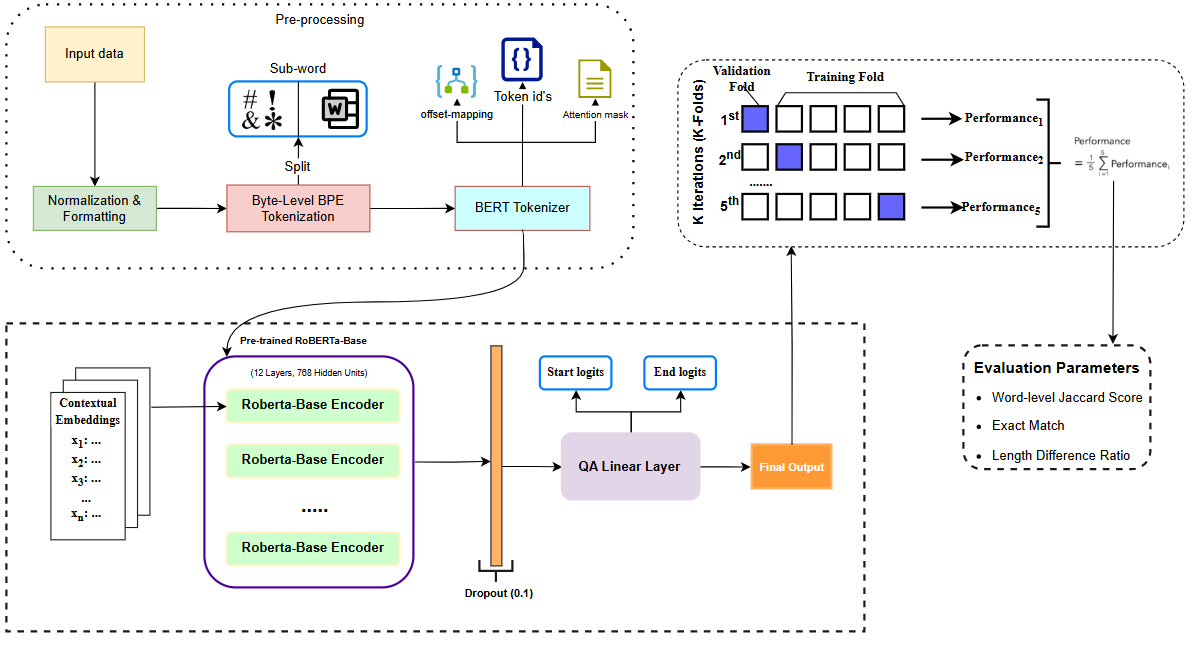

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Import Libraries and Config

In [5]:
import os
import re
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Cấu hình
class Config:
    SEED = 42
    MAX_LEN = 96            # Tăng nhẹ để bao quát hết
    BATCH_SIZE = 32         # 32 ổn định hơn 64 cho việc học
    EPOCHS = 4
    LEARNING_RATE = 3e-5    # Tinh chỉnh LR
    MODEL_NAME = "roberta-base" # RoBERTa tốt hơn DistilBERT cho task này
    TRAIN_FILE = '/content/train.csv'
    TEST_FILE  = '/content/test.csv'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(Config.SEED)
print(f"Setup complete. Device: {Config.DEVICE}")




Setup complete. Device: cuda


# **2. Data Loading & Input Identification**
Explanation: Loads the training and testing datasets and defines the Input (Context: tweet text, Question: sentiment) and Output (Selected text) for the span extraction task.

Loading Data...

--- Dataset Overview ---
Train columns: ['textID', 'text', 'selected_text', 'sentiment']
Test columns : ['textID', 'text', 'sentiment']

Train Shape: (27480, 4)
Test Shape : (3534, 3)

Train sample (head):
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861  Sons of ****, why couldn`t they put them on th...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  

Test sample (head):
       textID                            

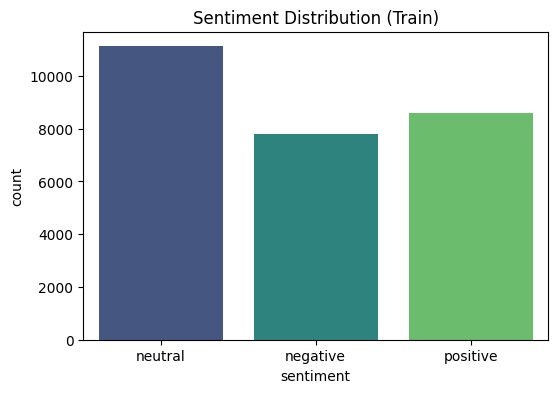

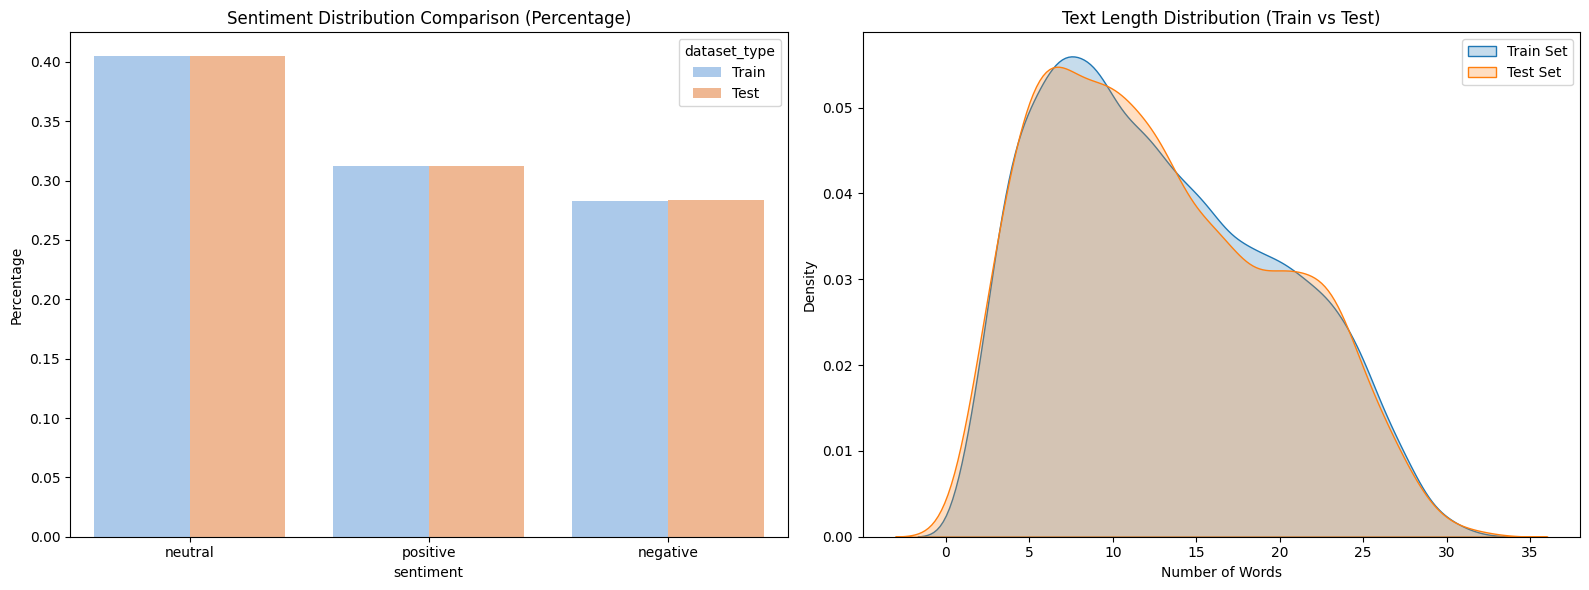

In [6]:
print("Loading Data...")
df_train = pd.read_csv(Config.TRAIN_FILE)
df_test = pd.read_csv(Config.TEST_FILE)

# =========================
# DATA INSPECTION (Quick Look)
# =========================
print("\n--- Dataset Overview ---")
print("Train columns:", df_train.columns.tolist())
print("Test columns :", df_test.columns.tolist())

# =========================
# Xử lý NaN và string
# =========================
df_train.dropna(subset=['text', 'sentiment'], inplace=True)
df_train['text'] = df_train['text'].astype(str).str.strip()
df_train['selected_text'] = df_train['selected_text'].astype(str).str.strip()

# Loại bỏ dòng mà selected_text rỗng hoặc text rỗng
df_train = df_train[df_train['text'] != ""]
df_train = df_train[df_train['selected_text'] != ""]
df_train.reset_index(drop=True, inplace=True)

# --- ADDED ---
print(f"\nTrain Shape: {df_train.shape}")
print(f"Test Shape : {df_test.shape}")

print("\nTrain sample (head):")
print(df_train.head(5))
print("\nTest sample (head):")
print(df_test.head(5))

import re

url_pattern = r"http[s]?://\S+"
df_train['has_url'] = df_train['text'].str.contains(url_pattern, regex=True)
# print(f"Proportion of tweets containing URLs: {df_train['has_url'].mean():.4f}")

def special_char_ratio(s):
    s = str(s)
    if len(s) == 0:
        return 0
    return sum(1 for c in s if not c.isalnum() and not c.isspace()) / len(s)

df_train['special_char_ratio'] = df_train['text'].apply(special_char_ratio)
# print(f"Average special character ratio: {df_train['special_char_ratio'].mean():.4f}")

print("\nExamples with many special characters:")
print(
    df_train.sort_values('special_char_ratio', ascending=False)
    .head(3)[['text', 'selected_text']]
)

# =========================
# Visualize Sentiment Distribution
# =========================
plt.figure(figsize=(6, 4))
sns.countplot(x=df_train['sentiment'], palette="viridis")
plt.title("Sentiment Distribution (Train)")
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================
# 1. Chuẩn bị dữ liệu
# =========================
# Tạo cột đếm số từ cho cả 2 tập
df_train['num_words'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['text'].apply(lambda x: len(str(x).split()))

# Gán nhãn để gộp dữ liệu vẽ biểu đồ
df_train['dataset_type'] = 'Train'
df_test['dataset_type'] = 'Test'

# Gộp tạm thời chỉ để vẽ biểu đồ so sánh
df_combined = pd.concat([
    df_train[['sentiment', 'num_words', 'dataset_type']],
    df_test[['sentiment', 'num_words', 'dataset_type']]
], axis=0)

# =========================
# 2. Vẽ Biểu đồ
# =========================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BIỂU ĐỒ 1: So sánh tỷ lệ Sentiment (Train vs Test)
prop_train = df_train['sentiment'].value_counts(normalize=True).reset_index()
prop_train['dataset_type'] = 'Train'
prop_test = df_test['sentiment'].value_counts(normalize=True).reset_index()
prop_test['dataset_type'] = 'Test'
prop_combined = pd.concat([prop_train, prop_test])
prop_combined.columns = ['sentiment', 'percentage', 'dataset_type']

sns.barplot(
    x='sentiment',
    y='percentage',
    hue='dataset_type',
    data=prop_combined,
    ax=axes[0],
    palette='pastel'
)
axes[0].set_title("Sentiment Distribution Comparison (Percentage)")
axes[0].set_ylabel("Percentage")

# BIỂU ĐỒ 2: So sánh độ dài câu (Word Count Distribution)
sns.kdeplot(data=df_train['num_words'], label='Train Set', shade=True, ax=axes[1])
sns.kdeplot(data=df_test['num_words'], label='Test Set', shade=True, ax=axes[1])
axes[1].set_title("Text Length Distribution (Train vs Test)")
axes[1].set_xlabel("Number of Words")
axes[1].legend()

plt.tight_layout()
plt.show()


# **3. Data  Preprocessing and Tokenization (Offset Mapping)**
Explaination: Implements the RoBERTa tokenizer combined with Robust Offset Mapping. This technique resolves the Alignment Issue by creating a precise mapping between the original character positions and the generated token IDs, ensuring the model trains on the correct span targets.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.texts = df['text'].values
        self.selected_texts = df['selected_text'].values if 'selected_text' in df.columns else None
        self.sentiments = df['sentiment'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = " " + " ".join(str(self.texts[idx]).split()) # Chuẩn hóa khoảng trắng nhẹ
        selected_text = " " + " ".join(str(self.selected_texts[idx]).split()) if self.selected_texts is not None else None

        # Tokenize
        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_offsets_mapping=True
        )

        ids = torch.tensor(enc['input_ids'], dtype=torch.long)
        mask = torch.tensor(enc['attention_mask'], dtype=torch.long)
        offsets = enc['offset_mapping']

        # Tìm Start/End Index của Token
        target_start = 0
        target_end = 0

        if selected_text is not None:
            # Tìm vị trí character bắt đầu và kết thúc của selected_text trong text
            idx_start = text.find(selected_text)
            idx_end = idx_start + len(selected_text)

            chars = [0] * len(text)
            if idx_start != -1:
                for i in range(idx_start, idx_end):
                    chars[i] = 1

                # Mapping Character -> Token
                tokens_indices = []
                for i, (o_start, o_end) in enumerate(offsets):
                    if o_start == o_end: continue # Skip padding/special
                    # Nếu token chứa bất kỳ ký tự nào được đánh dấu -> chọn token đó
                    if sum(chars[o_start:o_end]) > 0:
                        tokens_indices.append(i)

                if len(tokens_indices) > 0:
                    target_start = tokens_indices[0]
                    target_end = tokens_indices[-1]

        return {
            'ids': ids,
            'mask': mask,
            'targets_start': torch.tensor(target_start, dtype=torch.long),
            'targets_end': torch.tensor(target_end, dtype=torch.long),
            'text': text,
            'selected_text': selected_text if selected_text else "",
            'sentiment': self.sentiments[idx],
            'offsets': torch.tensor(offsets, dtype=torch.long)
        }

# Test Dataset
temp_ds = TweetDataset(df_train.iloc[:5], tokenizer, Config.MAX_LEN)
print("Sample Dataset Output Keys:", temp_ds[0].keys())


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Sample Dataset Output Keys: dict_keys(['ids', 'mask', 'targets_start', 'targets_end', 'text', 'selected_text', 'sentiment', 'offsets'])


# **4. Dataset Class Definition**
Explaination: Defines the cutom TweetDataset class. This class handles the conversion of raw tweets and sentiments into the specific tensor formats required by the model, including input_ids, attention_mask, and token_type_ids.

In [ ]:
class TweetModel(nn.Module):
    def __init__(self):
        super(TweetModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(Config.MODEL_NAME)
        self.drop = nn.Dropout(0.1)
        # 2 đầu ra: 1 cho start index, 1 cho end index
        self.l0 = nn.Linear(768, 2)

        # Init weights
        torch.nn.init.normal_(self.l0.weight, std=0.02)

    def forward(self, ids, mask):
        # Lấy hidden states
        out = self.roberta(ids, attention_mask=mask)
        last_hidden_state = out.last_hidden_state # (batch, seq_len, 768)

        out = self.drop(last_hidden_state)
        logits = self.l0(out) # (batch, seq_len, 2)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1) # (batch, seq_len)
        end_logits = end_logits.squeeze(-1)     # (batch, seq_len)

        return start_logits, end_logits

print("Model Architecture initialized.")

Model Architecture initialized.


# **5. Metric Calculation Utilities**
Explanation: Defines the compute_metrics function to evaluate prediction accuracy comprehensively. Beyond the primary Jaccard Score, it calculates Exact Match (EM), F1 Score, and Boundary Mean Absolute Error (MAE). These metrics provide granular insight into how close the predicted start/end indices are to the ground truth.

In [ ]:
# CELL 4
def compute_metrics(eval_pred):
    start_logits, end_logits = eval_pred.predictions
    start_positions, end_positions = eval_pred.label_ids

    pred_starts = np.argmax(start_logits, axis=-1)
    pred_ends = np.argmax(end_logits, axis=-1)

    jaccard_scores = []
    exact_matches = 0
    f1_scores = []
    start_acc_count = 0
    end_acc_count = 0
    start_errors = []
    end_errors = []
    length_ratios = []

    total = len(start_positions)

    for i in range(total):
        # Boundary Acc
        if start_positions[i] == pred_starts[i]: start_acc_count += 1
        if end_positions[i] == pred_ends[i]: end_acc_count += 1

        # MAE
        start_errors.append(abs(start_positions[i] - pred_starts[i]))
        end_errors.append(abs(end_positions[i] - pred_ends[i]))

        # Ranges
        pred_set = set(range(pred_starts[i], pred_ends[i] + 1)) if pred_ends[i] >= pred_starts[i] else set()
        true_set = set(range(start_positions[i], end_positions[i] + 1)) if end_positions[i] >= start_positions[i] else set()

        # Jaccard
        intersection = len(pred_set.intersection(true_set))
        union = len(pred_set.union(true_set))
        jaccard = intersection / union if union > 0 else 0.0
        jaccard_scores.append(jaccard)

        # Exact Match
        if pred_starts[i] == start_positions[i] and pred_ends[i] == end_positions[i]:
            exact_matches += 1

        # F1
        if len(pred_set) == 0 and len(true_set) == 0: f1 = 1.0
        elif len(pred_set) == 0 or len(true_set) == 0: f1 = 0.0
        else:
            prec = intersection / len(pred_set)
            rec = intersection / len(true_set)
            f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        f1_scores.append(f1)

        # Length Ratio
        pred_len = max(0, pred_ends[i] - pred_starts[i] + 1)
        true_len = max(0, end_positions[i] - start_positions[i] + 1)
        ratio = pred_len / true_len if true_len > 0 else (1.0 if pred_len == 0 else 0.0)
        length_ratios.append(ratio)

    return {
        "jaccard": np.mean(jaccard_scores),
        "exact_match": exact_matches / total,
        "f1": np.mean(f1_scores),
        "start_acc": start_acc_count / total,
        "end_acc": end_acc_count / total,
        "mae_start": np.mean(start_errors),
        "mae_end": np.mean(end_errors),
        "length_ratio": np.mean(length_ratios)
    }

print("Metrics function defined.")


✅ Metrics function defined.


# **6. Training & Inference Helper Functions (with Post-processing)**
Explanation: "Optimization Techniques". Defines the core execution loops:

- train_fn: Handles the forward pass, loss calculation, and backpropagation to update model weights.

- eval_fn: Handles validation/inference. Crucially, this function implements the "Neutral Trick" (automatically selecting the full text for neutral sentiment) and Decoding Logic (correcting instances where the predicted start index is greater than the end index) to optimize the final output.

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    total_loss = 0

    # Progress bar
    # pbar = tqdm(data_loader, total=len(data_loader), desc="Training")

    for d in data_loader:
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        ts = d['targets_start'].to(device)
        te = d['targets_end'].to(device)

        optimizer.zero_grad()

        start_logits, end_logits = model(ids, mask)

        loss = nn.CrossEntropyLoss()(start_logits, ts) + nn.CrossEntropyLoss()(end_logits, te)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    temp_preds = []

    with torch.no_grad():
        for d in data_loader:
            ids = d['ids'].to(device)
            mask = d['mask'].to(device)
            text = d['text']
            sentiment = d['sentiment']
            offsets = d['offsets'].cpu().numpy()

            start_logits, end_logits = model(ids, mask)

            start_prob = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
            end_prob = torch.softmax(end_logits, dim=1).cpu().detach().numpy()

            for i in range(len(ids)):
                start_idx = np.argmax(start_prob[i])
                end_idx = np.argmax(end_prob[i])

                # Quy tắc hậu xử lý (Post-processing rule)
                if start_idx > end_idx:
                    end_idx = start_idx

                # Neutral Trick: Nếu neutral, thường là lấy cả câu
                if sentiment[i] == "neutral" or len(text[i].split()) < 2:
                    pred_text = text[i]
                else:
                    pred_text = ""
                    if start_idx < len(offsets[i]) and end_idx < len(offsets[i]):
                        os = offsets[i]
                        # Lấy span từ offset
                        pred_text = text[i][os[start_idx][0]:os[end_idx][1]]

                temp_preds.append(pred_text)

    return temp_preds

def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

print("Training utils ready.")


Training utils ready.


# **7. Baseline Model Evaluation**
Explanation: "Performance Evaluation". Establishes a "Naive Baseline" by assuming the selected text is simply the entire tweet for all samples. Evaluating this strategy yields a Jaccard score (approx. 0.58 - 0.61), serving as a benchmark to measure the actual performance gain achieved by the fine-tuned RoBERTa model.

In [ ]:
import pandas as pd
import numpy as np

TRAIN_FILE = "/train.csv"
TEST_FILE  = "/test.csv"

df = pd.read_csv(TRAIN_FILE)
df.dropna(subset=['text', 'sentiment', 'selected_text'], inplace=True)

def jaccard_word(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c)) if (len(a) + len(b) - len(c)) > 0 else 0.0

def jaccard_char(str1, str2):
    a = set(str1.lower())
    b = set(str2.lower())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c)) if (len(a) + len(b) - len(c)) > 0 else 0.0

def evaluate_baseline_detailed(df):
    print("Running Detailed Baseline Evaluation (Strategy: Predict = Full Text)")

    results = {
        'sentiment': [],
        'jaccard_word': [],
        'jaccard_char': [],
        'exact_match': [],
        'pred_len': [],
        'true_len': []
    }

    for _, row in df.iterrows():
        pred = str(row['text']).strip()
        true = str(row['selected_text']).strip()
        sentiment = row['sentiment']

        jw = jaccard_word(pred, true)
        jc = jaccard_char(pred, true)
        em = 1 if pred == true else 0

        results['sentiment'].append(sentiment)
        results['jaccard_word'].append(jw)
        results['jaccard_char'].append(jc)
        results['exact_match'].append(em)
        results['pred_len'].append(len(pred))
        results['true_len'].append(len(true))

    df_results = pd.DataFrame(results)

    print("\n" + "="*50)
    print("BASELINE DETAILED EVALUATION REPORT")
    print("Strategy: Predict = Full Text (Naive Baseline)")
    print("="*50)

    print(f"Mean Jaccard (Word-Level) : {df_results['jaccard_word'].mean():.4f}")
    print(f"Mean Jaccard (Char-Level) : {df_results['jaccard_char'].mean():.4f}")
    print(f"Exact Match              : {df_results['exact_match'].mean():.4f}")

    mean_ratio = (df_results['pred_len'] / (df_results['true_len'] + 1e-6)).mean()
    print(f"Length Ratio (Pred/True) : {mean_ratio:.4f}")

    print("-" * 50)
    breakdown = df_results.groupby('sentiment')[['jaccard_word', 'jaccard_char', 'exact_match']].mean()
    print(breakdown)
    print("="*50)

    return df_results

_ = evaluate_baseline_detailed(df)

print("Generating Baseline Submission for Test Data")
df_test = pd.read_csv(TEST_FILE)
df_test['selected_text'] = df_test['text']
submission_file = "submission_baseline.csv"
df_test[['textID', 'selected_text']].to_csv(submission_file, index=False)
print(f"Submission file saved: {submission_file}")


Running Detailed Baseline Evaluation (Strategy: Predict = Full Text)

BASELINE DETAILED EVALUATION REPORT
Strategy: Predict = Full Text (Naive Baseline)
Mean Jaccard (Word-Level) : 0.5891
Mean Jaccard (Char-Level) : 0.6950
Exact Match              : 0.4462
Length Ratio (Pred/True) : 5.1027
--------------------------------------------------
           jaccard_word  jaccard_char  exact_match
sentiment                                         
negative       0.338613      0.513489     0.146639
neutral        0.976445      0.983542     0.899883
positive       0.314372      0.485943     0.130156
Generating Baseline Submission for Test Data
Submission file saved: submission_baseline.csv


# **8. Main Training Loop With 5-Fold Cross-Validation**
Explanation: Executes the rigorous 5-Fold Cross-Validation strategy. The code iterates through 5 folds, initializing a fresh model for each to ensure objective evaluation. It tracks detailed metrics in real-time and saves the best-performing model weights (best_model.bin) to prevents overfitting.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import StratifiedKFold

# --- Helper to calculate token-level metrics manually inside the loop ---
# (Re-using the logic from your compute_metrics function but adapted for the loop)
def calculate_detailed_metrics(pred_starts, pred_ends, true_starts, true_ends, val_preds, val_targets):
    # 1. Jaccard
    jaccard_scores = [jaccard(p, t) for p, t in zip(val_preds, val_targets)]
    mean_jaccard = np.mean(jaccard_scores)

    # 2. Exact Match
    exact_matches = np.sum((pred_starts == true_starts) & (pred_ends == true_ends))
    exact_match_score = exact_matches / len(pred_starts)

    # 3. Boundary Errors (MAE)
    mae_start = np.mean(np.abs(pred_starts - true_starts))
    mae_end = np.mean(np.abs(pred_ends - true_ends))

    return mean_jaccard, exact_match_score, mae_start, mae_end

# --- 1. Start Timer ---
start_time_total = time.time()

# Split Data
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.SEED)

history = {'train_loss': [], 'val_jaccard': [], 'val_em': []}
best_jaccard = 0

print(">>> Starting Training with Detailed Evaluation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, df_train['sentiment'])):
    print(f"\n--- Fold {fold + 1}/5 ---")

    train_data = df_train.iloc[train_idx]
    val_data = df_train.iloc[val_idx]

    train_dataset = TweetDataset(train_data, tokenizer, Config.MAX_LEN)
    val_dataset = TweetDataset(val_data, tokenizer, Config.MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0)

    model = TweetModel()
    model.to(Config.DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    num_train_steps = int(len(train_dataset) / Config.BATCH_SIZE * Config.EPOCHS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

    for epoch in range(Config.EPOCHS):
        epoch_start = time.time()

        # --- TRAIN ---
        train_loss = train_fn(train_loader, model, optimizer, Config.DEVICE, scheduler)

        # --- VALIDATE (Updated for Detailed Metrics) ---
        # Note: We need both raw indices (for accuracy) and decoded text (for Jaccard)
        model.eval()
        all_pred_starts = []
        all_pred_ends = []
        all_true_starts = []
        all_true_ends = []

        with torch.no_grad():
            for d in val_loader:
                ids = d['ids'].to(Config.DEVICE)
                mask = d['mask'].to(Config.DEVICE)
                ts = d['targets_start'].cpu().numpy()
                te = d['targets_end'].cpu().numpy()

                s_logits, e_logits = model(ids, mask)

                # Get predicted indices
                p_starts = torch.argmax(s_logits, dim=1).cpu().numpy()
                p_ends = torch.argmax(e_logits, dim=1).cpu().numpy()

                all_pred_starts.extend(p_starts)
                all_pred_ends.extend(p_ends)
                all_true_starts.extend(ts)
                all_true_ends.extend(te)

        # Convert to numpy arrays
        all_pred_starts = np.array(all_pred_starts)
        all_pred_ends = np.array(all_pred_ends)
        all_true_starts = np.array(all_true_starts)
        all_true_ends = np.array(all_true_ends)

        # Get Text Predictions for Jaccard
        val_preds = eval_fn(val_loader, model, Config.DEVICE)
        val_targets = val_data['selected_text'].values

        # --- CALCULATE METRICS ---
        mean_jaccard, em_score, mae_s, mae_e = calculate_detailed_metrics(
            all_pred_starts, all_pred_ends, all_true_starts, all_true_ends, val_preds, val_targets
        )

        epoch_end = time.time()
        epoch_mins, epoch_secs = divmod(epoch_end - epoch_start, 60)

        print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Time: {int(epoch_mins)}m {int(epoch_secs)}s")
        print(f"   >> Jaccard: {mean_jaccard:.4f} | Exact Match: {em_score:.4f}")
        print(f"   >> Boundary MAE: Start={mae_s:.2f}, End={mae_e:.2f}")

        history['train_loss'].append(train_loss)
        history['val_jaccard'].append(mean_jaccard)

        if mean_jaccard > best_jaccard:
            best_jaccard = mean_jaccard
            torch.save(model.state_dict(), "best_model.bin")
            print("   >>> Best Model Saved!")

    # break # Remove break to run all folds

# --- End Timer ---
end_time_total = time.time()
total_seconds = end_time_total - start_time_total
hours, remainder = divmod(total_seconds, 3600)
minutes, seconds = divmod(remainder, 60)

print("="*40)
print(f"FINAL RESULT: Total Execution Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")
print("="*40)



>>> Starting Training with Detailed Evaluation...

--- Fold 1/5 ---


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Loss: 2.7063 | Time: 6m 49s
   >> Jaccard: 0.6597 | Exact Match: 0.4467
   >> Boundary MAE: Start=2.88, End=3.91
   >>> Best Model Saved!
Epoch 2 | Loss: 2.1056 | Time: 6m 57s
   >> Jaccard: 0.6565 | Exact Match: 0.4614
   >> Boundary MAE: Start=2.75, End=3.94
Epoch 3 | Loss: 1.9299 | Time: 6m 56s
   >> Jaccard: 0.6688 | Exact Match: 0.4596
   >> Boundary MAE: Start=2.92, End=3.87
   >>> Best Model Saved!
Epoch 4 | Loss: 1.7864 | Time: 6m 57s
   >> Jaccard: 0.6633 | Exact Match: 0.4636
   >> Boundary MAE: Start=2.79, End=3.91

--- Fold 2/5 ---


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Loss: 2.5922 | Time: 6m 56s
   >> Jaccard: 0.6648 | Exact Match: 0.4480
   >> Boundary MAE: Start=2.75, End=4.05
Epoch 2 | Loss: 2.0656 | Time: 6m 56s
   >> Jaccard: 0.6876 | Exact Match: 0.4869
   >> Boundary MAE: Start=2.67, End=3.58
   >>> Best Model Saved!
Epoch 3 | Loss: 1.8411 | Time: 6m 57s
   >> Jaccard: 0.6826 | Exact Match: 0.4894
   >> Boundary MAE: Start=2.69, End=3.54
Epoch 4 | Loss: 1.6621 | Time: 6m 56s
   >> Jaccard: 0.6809 | Exact Match: 0.4838
   >> Boundary MAE: Start=2.70, End=3.59

--- Fold 3/5 ---


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Loss: 2.5604 | Time: 6m 56s
   >> Jaccard: 0.6358 | Exact Match: 0.4682
   >> Boundary MAE: Start=2.96, End=3.93
Epoch 2 | Loss: 2.0274 | Time: 6m 56s
   >> Jaccard: 0.6734 | Exact Match: 0.4814
   >> Boundary MAE: Start=2.65, End=3.49
Epoch 3 | Loss: 1.8328 | Time: 6m 56s
   >> Jaccard: 0.6709 | Exact Match: 0.4925
   >> Boundary MAE: Start=2.70, End=3.48
Epoch 4 | Loss: 1.6648 | Time: 6m 56s
   >> Jaccard: 0.6732 | Exact Match: 0.4789
   >> Boundary MAE: Start=2.76, End=3.58

--- Fold 4/5 ---


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Loss: 2.5411 | Time: 6m 56s
   >> Jaccard: 0.6709 | Exact Match: 0.4783
   >> Boundary MAE: Start=2.87, End=3.61
Epoch 2 | Loss: 2.0145 | Time: 6m 56s
   >> Jaccard: 0.6799 | Exact Match: 0.4760
   >> Boundary MAE: Start=2.81, End=3.49
Epoch 3 | Loss: 1.8202 | Time: 6m 57s
   >> Jaccard: 0.6720 | Exact Match: 0.4765
   >> Boundary MAE: Start=2.80, End=3.68
Epoch 4 | Loss: 1.6555 | Time: 6m 56s
   >> Jaccard: 0.6786 | Exact Match: 0.4771
   >> Boundary MAE: Start=2.79, End=3.60

--- Fold 5/5 ---


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Loss: 2.5756 | Time: 6m 56s
   >> Jaccard: 0.6639 | Exact Match: 0.4614
   >> Boundary MAE: Start=2.81, End=3.65
Epoch 2 | Loss: 2.0249 | Time: 6m 56s
   >> Jaccard: 0.6692 | Exact Match: 0.4807
   >> Boundary MAE: Start=2.67, End=3.64
Epoch 3 | Loss: 1.8298 | Time: 6m 56s
   >> Jaccard: 0.6676 | Exact Match: 0.4802
   >> Boundary MAE: Start=2.67, End=3.71
Epoch 4 | Loss: 1.6598 | Time: 6m 56s
   >> Jaccard: 0.6750 | Exact Match: 0.4849
   >> Boundary MAE: Start=2.73, End=3.71
✅ FINAL RESULT: Total Execution Time: 2h 19m 33s


# **9. Final Evaluation & Visualization**

>>> Running Detailed Evaluation...


Evaluating: 100%|██████████| 172/172 [00:27<00:00,  6.17it/s]



FINAL DETAILED EVALUATION REPORT
1️ Mean Jaccard (Word-Level)   : 0.6750 (Primary)
 Mean Jaccard (Char-Level)   : 0.7451 (Project Req)
 Exact Match (Strict)        : 0.5369
 Length Ratio (Pred/True)    : 1.8846
--------------------------------------------------
Score Breakdown by Sentiment:
           jaccard_word  jaccard_char  exact_match
sentiment                                         
negative       0.459929      0.583304     0.275707
neutral        0.980223      0.984826     0.907332
positive       0.474761      0.581342     0.294118


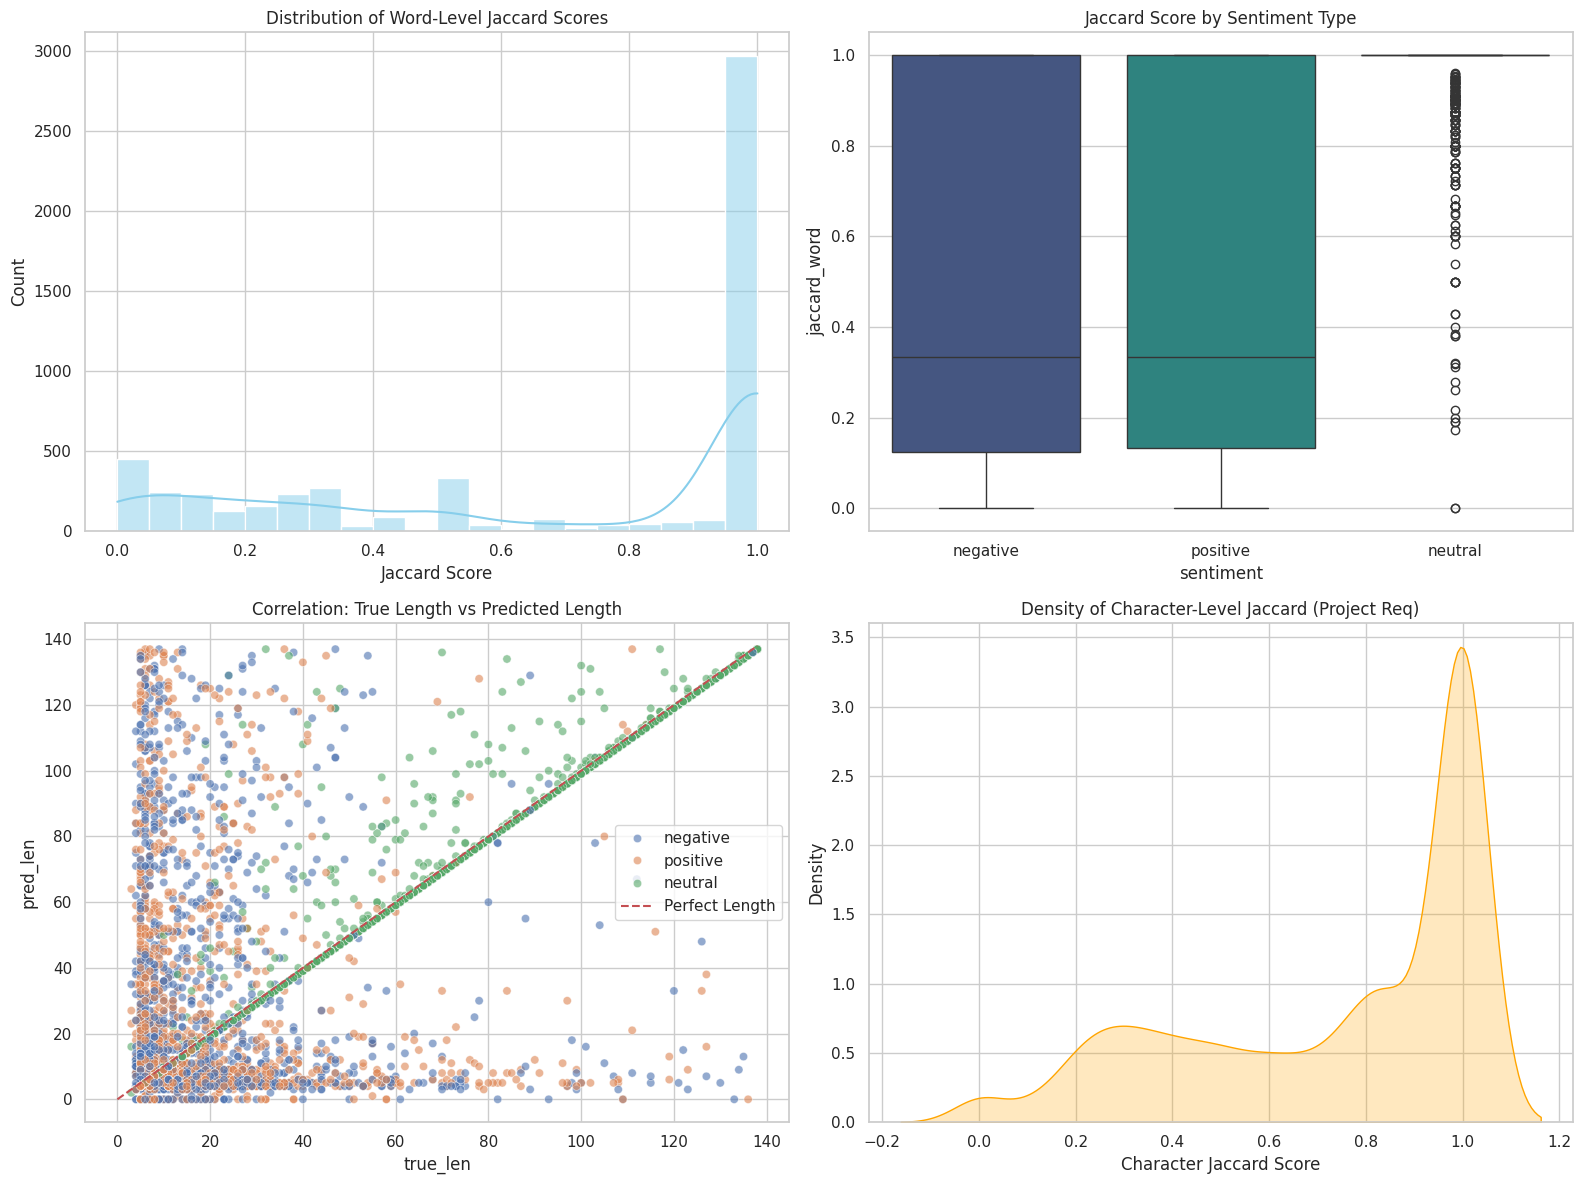

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

class DetailedEvaluator:
    def __init__(self, model, data_loader, device, tokenizer):
        self.model = model
        self.data_loader = data_loader
        self.device = device
        self.tokenizer = tokenizer

    def jaccard_word(self, str1, str2):
        a = set(str1.lower().split())
        b = set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c)) if (len(a) + len(b) - len(c)) > 0 else 0.0

    def jaccard_char(self, str1, str2):
        """Metric yêu cầu cho đồ án: Character-level Jaccard"""
        a = set(str1.lower())
        b = set(str2.lower())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c)) if (len(a) + len(b) - len(c)) > 0 else 0.0

    def run_evaluation(self):
        self.model.eval()

        results = {
            'true_text': [],
            'pred_text': [],
            'jaccard_word': [],
            'jaccard_char': [],
            'exact_match': [],
            'pred_len': [],
            'true_len': [],
            'sentiment': [] # Để phân tích theo từng loại sentiment
        }

        print(">>> Running Detailed Evaluation...")
        with torch.no_grad():
            for d in tqdm(self.data_loader, desc="Evaluating"):
                ids = d['ids'].to(self.device)
                mask = d['mask'].to(self.device)
                orig_texts = d['text']
                targets = d['selected_text']
                sentiments = d['sentiment']
                offsets = d['offsets'].cpu().numpy()

                # Model Inference
                start_logits, end_logits = self.model(ids, mask)

                # Get Indices
                start_prob = torch.softmax(start_logits, dim=1).cpu().numpy()
                end_prob = torch.softmax(end_logits, dim=1).cpu().numpy()

                pred_starts = np.argmax(start_prob, axis=1)
                pred_ends = np.argmax(end_prob, axis=1)

                # Decoding logic
                for i in range(len(ids)):
                    # Logic xử lý offset để lấy text
                    idx_start = pred_starts[i]
                    idx_end = pred_ends[i]

                    if idx_start > idx_end: idx_end = idx_start # Fix lỗi logic

                    # Quy tắc Neutral (thường lấy cả câu)
                    if sentiments[i] == "neutral" or len(orig_texts[i].split()) < 2:
                         decoded_pred = orig_texts[i]
                    else:
                        # Lấy text từ offset mapping
                        os = offsets[i]
                        if idx_start < len(os) and idx_end < len(os):
                            decoded_pred = orig_texts[i][os[idx_start][0]:os[idx_end][1]]
                        else:
                            decoded_pred = orig_texts[i] # Fallback

                    target_text = str(targets[i])
                    decoded_pred = str(decoded_pred).strip()

                    # --- Calculate Metrics Per Sample ---
                    jw = self.jaccard_word(target_text, decoded_pred)
                    jc = self.jaccard_char(target_text, decoded_pred)
                    em = 1 if target_text.strip() == decoded_pred.strip() else 0

                    results['true_text'].append(target_text)
                    results['pred_text'].append(decoded_pred)
                    results['jaccard_word'].append(jw)
                    results['jaccard_char'].append(jc)
                    results['exact_match'].append(em)
                    results['pred_len'].append(len(decoded_pred))
                    results['true_len'].append(len(target_text))
                    results['sentiment'].append(sentiments[i])

        return pd.DataFrame(results)

    def print_report(self, df_results):
        print("\n" + "="*50)
        print("FINAL DETAILED EVALUATION REPORT")
        print("="*50)

        # 1. Overall Metrics
        print(f"1️ Mean Jaccard (Word-Level)   : {df_results['jaccard_word'].mean():.4f} (Primary)")
        print(f" Mean Jaccard (Char-Level)   : {df_results['jaccard_char'].mean():.4f} (Project Req)")
        print(f" Exact Match (Strict)        : {df_results['exact_match'].mean():.4f}")

        # 4. Length Ratio
        mean_ratio = (df_results['pred_len'] / (df_results['true_len'] + 1e-6)).mean()
        print(f" Length Ratio (Pred/True)    : {mean_ratio:.4f}")


        print("-" * 50)
        print("Score Breakdown by Sentiment:")
        print(df_results.groupby('sentiment')[['jaccard_word', 'jaccard_char', 'exact_match']].mean())
        print("="*50)

    def visualize(self, df_results):
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Jaccard Score Distribution
        sns.histplot(df_results['jaccard_word'], bins=20, kde=True, ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title('Distribution of Word-Level Jaccard Scores')
        axes[0, 0].set_xlabel('Jaccard Score')

        # Plot 2: Boxplot by Sentiment
        sns.boxplot(x='sentiment', y='jaccard_word', data=df_results, ax=axes[0, 1], palette='viridis')
        axes[0, 1].set_title('Jaccard Score by Sentiment Type')

        # Plot 3: Predicted Length vs True Length
        sns.scatterplot(x='true_len', y='pred_len', hue='sentiment', data=df_results, ax=axes[1, 0], alpha=0.6)
        # Đường chuẩn y=x
        max_val = max(df_results['true_len'].max(), df_results['pred_len'].max())
        axes[1, 0].plot([0, max_val], [0, max_val], 'r--', label='Perfect Length')
        axes[1, 0].set_title('Correlation: True Length vs Predicted Length')
        axes[1, 0].legend()

        # Plot 4: Character Jaccard Distribution
        sns.kdeplot(df_results['jaccard_char'], shade=True, ax=axes[1, 1], color='orange')
        axes[1, 1].set_title('Density of Character-Level Jaccard (Project Req)')
        axes[1, 1].set_xlabel('Character Jaccard Score')

        plt.tight_layout()
        plt.show()

evaluator = DetailedEvaluator(model, val_loader, Config.DEVICE, tokenizer)
df_results = evaluator.run_evaluation()
evaluator.print_report(df_results)
evaluator.visualize(df_results)

# 10. INFERENCE ON NEW DATA


In [ ]:
# ==========================================
# BƯỚC 7: INFERENCE ON NEW DATA (50 SAMPLES)
# ==========================================
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# 1. Tạo dữ liệu mới (Hỗn hợp: Tự nhập + Lấy từ Test set)
# -------------------------------------------------------

manual_data = [
    {"text": "I absolutely love this movie, the acting was brilliant!", "sentiment": "positive"},
    {"text": "The service was terrible and the food was cold.", "sentiment": "negative"},
    {"text": "I am just walking to the park.", "sentiment": "neutral"},
    {"text": "My car broke down in the middle of the highway, so sad.", "sentiment": "negative"},
    {"text": "Wow, what a beautiful morning to start a new job.", "sentiment": "positive"}
]
df_manual = pd.DataFrame(manual_data)

# B. 45 Câu ngẫu nhiên từ tập Test (để đạt đủ ~50 mẫu như yêu cầu)
# Lưu ý: Tập test là dữ liệu model chưa được học, nên dùng làm inference
if 'df_test' in globals():
    # Lấy 45 dòng ngẫu nhiên từ df_test
    df_sample_test = df_test.sample(n=45, random_state=42)[['text', 'sentiment']]
else:
    # Fallback nếu chưa load df_test
    df_temp = pd.read_csv(Config.TEST_FILE)
    df_sample_test = df_temp.sample(n=45, random_state=42)[['text', 'sentiment']]

# C. Gộp lại thành tập dữ liệu Inference (~50 dòng)
df_inference = pd.concat([df_manual, df_sample_test]).reset_index(drop=True)
print(f"Đã chuẩn bị dữ liệu Inference: {len(df_inference)} dòng.")

# 2. Chuẩn bị Dataset & DataLoader
# -------------------------------------------------------
# Reuse TweetDataset ( Dataset này sẽ tự xử lý việc thiếu cột 'selected_text')
inference_dataset = TweetDataset(df_inference, tokenizer, Config.MAX_LEN)
inference_loader = DataLoader(inference_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

# 3. Chạy Inference (Dự đoán)
# -------------------------------------------------------
model.eval()
predictions = []

print(">>> Đang chạy dự đoán trên dữ liệu mới...")
with torch.no_grad():
    for d in inference_loader:
        ids = d['ids'].to(Config.DEVICE)
        mask = d['mask'].to(Config.DEVICE)
        texts = d['text']
        offsets = d['offsets'].cpu().numpy()
        sentiments = d['sentiment']

        # Forward pass
        start_logits, end_logits = model(ids, mask)

        # Get probabilities
        start_prob = torch.softmax(start_logits, dim=1).cpu().numpy()
        end_prob = torch.softmax(end_logits, dim=1).cpu().numpy()

        # Get predicted indices
        pred_starts = np.argmax(start_prob, axis=1)
        pred_ends = np.argmax(end_prob, axis=1)

        # Decode kết quả
        for i in range(len(ids)):
            idx_start = pred_starts[i]
            idx_end = pred_ends[i]

            if idx_start > idx_end:
                idx_end = idx_start

            # Logic xử lý: Nếu là neutral hoặc câu quá ngắn -> lấy cả câu
            if sentiments[i] == "neutral" or len(texts[i].split()) < 2:
                pred_text = texts[i]
            else:
                os = offsets[i]
                # Map từ token index về string index
                if idx_start < len(os) and idx_end < len(os):
                    pred_text = texts[i][os[idx_start][0]:os[idx_end][1]]
                else:
                    pred_text = texts[i] # Fallback

            predictions.append(pred_text.strip())

# 4. Hiển thị kết quả
# -------------------------------------------------------
df_inference['Predicted_Selected_Text'] = predictions

print("\n" + "="*80)
print("KẾT QUẢ INFERENCE TRÊN 50 MẪU DỮ LIỆU MỚI")
print("="*80)
pd.set_option('display.max_colwidth', 100) # Để nhìn rõ text dài
display(df_inference.head(10))

df_inference.to_csv("inference_results_50_samples.csv", index=False)
print("\nĐã lưu kết quả chi tiết vào file: inference_results_50_samples.csv")

Đã chuẩn bị dữ liệu Inference: 50 dòng.
>>> Đang chạy dự đoán trên dữ liệu mới...

KẾT QUẢ INFERENCE TRÊN 50 MẪU DỮ LIỆU MỚI


,text,sentiment,Predicted_Selected_Text
0,"I absolutely love this movie, the acting was brilliant!",positive,"I absolutely love this movie, the acting was brilliant!"
1,The service was terrible and the food was cold.,negative,terrible
2,I am just walking to the park.,neutral,I am just walking to the park.
3,"My car broke down in the middle of the highway, so sad.",negative,sad.
4,"Wow, what a beautiful morning to start a new job.",positive,beautiful
5,Thank you so much phaoloo !!!!,positive,Thank you so much
6,Midnight ice-cream weather! So **** bored,negative,So **** bored
7,Ohh i forgot to tell you last night that when i was a alton towers i touched a shark it was ama...,positive,amazing
8,i am the only arabic girl who`s online every one is a sleep ..,neutral,i am the only arabic girl who`s online every one is a sleep ..
9,starting the video editing of the first spanking movie we did with Mina ... it will be added to ...,neutral,starting the video editing of the first spanking movie we did with Mina ... it will be added to ...



Đã lưu kết quả chi tiết vào file: inference_results_50_samples.csv


# **Output if the cell 10 do not display**

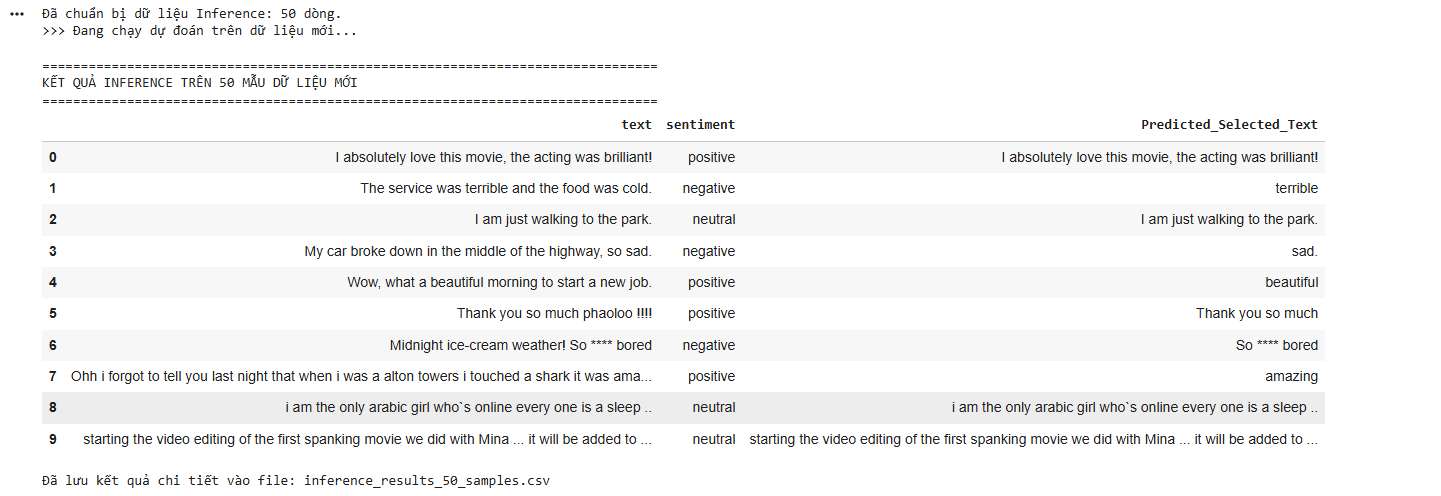